In [1]:
import sys
sys.version

'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np

import os
import matplotlib
import matplotlib.pyplot as plt

import random
%matplotlib inline

import shutil

import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers

from tensorflow.contrib.learn.python.learn import learn_runner

import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [5]:
tf.__version__

'1.3.0'

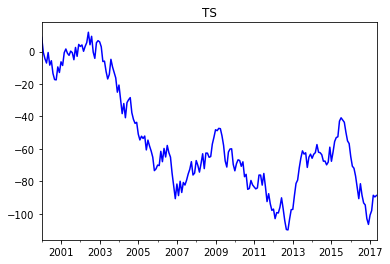

In [7]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='TS')
plt.show()

In [8]:
ts.head()

2000-01-31    8.828984
2000-02-29   -0.441352
2000-03-31   -4.292150
2000-04-30   -7.027543
2000-05-31   -0.532992
Freq: M, dtype: float64

In [10]:
ts = np.array(ts)
num_periods = 20
f_horizon = 1

x_data = ts[:(len(ts)-(len(ts) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = ts[1:(len(ts) - (len(ts) % num_periods)) + f_horizon]     # add the forecasting horizon to the y vector
y_batches = y_data.reshape(-1, num_periods, 1)

In [22]:
len(x_batches[0])

20

We have 209 total observations in our data. I want to make sure I have the same number of observations for each of my batch inputs.
What we see is our training data set is made up of 10 batches, containing 20 observations. Each observation is a sequence of a single value.

In [23]:
def test_data(series, forecast, num_periods):
    test_x_setup = ts[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = ts[-(num_periods):].reshape(-1, num_periods, 1)
    return testX, testY
    
X_test, Y_test = test_data(ts, f_horizon, num_periods)

In [26]:
type(X_test)

numpy.ndarray

Now that we have our data, let’s create our TensorFlow graph that will do the computation.

In [35]:
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.01

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(rnn_output, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [39]:
outputs

<tf.Tensor 'Reshape_1:0' shape=(?, 20, 1) dtype=float32>

There is a lot going on there, so let's examine one step at a time. We are specifying the number of periods we are using to predict. In this case, it is the number of sequences that we are feeding into the model as a single input. We specify our variable placeholders. We initialize a type of RNN cell to use (size 100) and the type of activation function we want. ReLU stands for “Rectified Linear Unit” and is the default activation function, but it can be changed to Sigmoid, Hyberbolic Tangent (Tanh), and others, if desired.

We want our outputs to be in the same format as our inputs so we can compare our results using the loss function. In this case, we are using mean squared error (MSE), since this is a regression problem, in which our goal is to minimize the difference between the actual and the predicted. If we were dealing with a classification outcome, we might use cross-entropy. Now that we have this loss function defined, it is possible to define the training operation in TensorFlow that will optimize our network of input and outputs. To execute the optimization, we will use the Adam optimizer. Adam optimizer is a great general-purpose optimizer that performs our gradient descent via backpropagation through time. This allows faster convergence at the cost of more computation.
Now it is time to implement this model on our training data.

In [44]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
        
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

InvalidArgumentError: Incompatible shapes: [1000,20,1] vs. [10,20,1]
	 [[Node: gradients/sub_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](gradients/sub_grad/Shape, gradients/sub_grad/Shape_1)]]

Caused by op 'gradients/sub_grad/BroadcastGradientArgs', defined at:
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-bf9673d055a1>", line 22, in <module>
    training_op = optimizer.minimize(loss)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\training\optimizer.py", line 315, in minimize
    grad_loss=grad_loss)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\training\optimizer.py", line 386, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\math_grad.py", line 700, in _SubGrad
    rx, ry = gen_array_ops._broadcast_gradient_args(sx, sy)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 393, in _broadcast_gradient_args
    name=name)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'sub', defined at:
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-bf9673d055a1>", line 20, in <module>
    loss = tf.reduce_sum(tf.square(outputs - y))
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2629, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [1000,20,1] vs. [10,20,1]
	 [[Node: gradients/sub_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](gradients/sub_grad/Shape, gradients/sub_grad/Shape_1)]]


introduction

https://mapr.com/blog/deep-learning-tensorflow/

seems good

http://mlbloggen.no/wp-content/uploads/2017/05/Fibonacci_seq_prediction.html